## Visualisations senor data

This notebook is based on the work of CHUN FU in his notebook viz-of-sleeping-time-series.ipynb

### Imports

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px


### Data

In [59]:
train_series = pd.read_parquet('../data/train_series.parquet')
test_series = pd.read_parquet('../data/test_series.parquet')
train_series.head(3)

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216


In [60]:
train_events = pd.read_csv('../data/train_events.csv')
train_events['date'] = train_events['timestamp'].str.split('T', expand=True)[0]
train_events['time'] = train_events['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
train_events['timestamp'] = pd.to_datetime(train_events['date']+' '+train_events['time'])
train_events['hour'] = train_events['timestamp'].dt.hour
train_events.head(3)

,series_id,night,event,step,timestamp,date,time,hour
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018-08-14,22:26:00,22.0
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018-08-15,06:41:00,6.0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018-08-15,19:37:00,19.0


In [61]:
train_series.head(6)

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215
5,038441c925bb,5,2018-08-14T15:30:25-0400,2.6367,0.0217


### Visualisations

In [62]:
pd.options.mode.chained_assignment = None  # default='warn'

In [63]:
def plot_series(series_id, train_series, train_events):
    # Filter the df's based on the series_id
    sample_series = train_series[train_series['series_id'] == series_id]
    sample_events = train_events[train_events['series_id'] == series_id]
    sample_onset = sample_events.loc[sample_events['event'] == 'onset', 'timestamp'].dropna()
    sample_wakeup = sample_events.loc[sample_events['event'] == 'wakeup', 'timestamp'].dropna()
    
        
    
    # Helper function to plot data 
    def plot_data(data, ylabel, events=False, area=False, baseline=False):
        plt.figure(figsize=(22, 4))
        plt.plot(sample_series['timestamp'], sample_series[data], label=data, linewidth=0.5, color='black')
        
        if events:
            for onset in sample_onset:
                plt.axvline(x=onset, color='#3352ff', linestyle='-', label='onset', linewidth=3.5)
            
            for wakeup in sample_wakeup:
                plt.axvline(x=wakeup, color='#ff7933', linestyle='-', label='wakeup', linewidth=3.5)
            
        if area:
            for i in range(len(sample_onset)):
                onset = sample_onset[i*2]
                wakeup = sample_wakeup[(i*2)+1]
                plt.fill_betweenx(y=[plt.ylim()[0], plt.ylim()[1]], x1=onset, x2=wakeup, color='#3352ff', alpha=0.3, label='sleep-window')
                        
        if baseline:
            unique_dates = sample_series['timestamp'].dt.date.unique()
            for i in range(len(unique_dates)-1):
                baseline_wakeup = pd.to_datetime(f'{unique_dates[i+1]} 06:30:00')
                baseline_onset = pd.to_datetime(f'{unique_dates[i]} 21:30:00')
                plt.axvline(x=baseline_onset, color='#3352ff', linestyle=':', label='onset baseline', linewidth=3.5)
                plt.axvline(x=baseline_wakeup, color='#ff7933', linestyle=':', label='wakeup baseline', linewidth=3.5)
            
        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)
        
        plt.legend(new_handles, new_labels, fontsize=16)
        plt.xlabel('Timestamp', fontsize=16, labelpad=15)
        plt.ylabel(ylabel, fontsize=16, labelpad=15)
        plt.title(f'{ylabel} over 3 nights', fontsize=18)
        plt.xticks(fontsize=16)  
        plt.yticks(fontsize=16)
        plt.tick_params(axis='both', which='both', length=8, width=1.5)
        plt.show()
    
    # Plot enmo and anglez
    plot_data('enmo', 'ENMO value')
    plot_data('anglez', 'anglez value')
    plot_data('enmo', 'ENMO value', events=True, area=False, baseline=False)
    plot_data('anglez', 'anglez value', events=True, area=False, baseline=False)
    plot_data('enmo', 'ENMO value', events=False, area=True, baseline=False)
    plot_data('anglez', 'anglez value', events=False, area=True, baseline=False)
    plot_data('enmo', 'ENMO value', events=False, area=True, baseline=True)
    plot_data('anglez', 'anglez value', events=False, area=True, baseline=True)

In [64]:
def prep_data(num_nights, serie, events, bin_size='2Min'):
    # only keep amount of nights as defined by num_nights
    subset_events = events[events['night'].isin(list(range(1, num_nights+1)))]
    
    # only keep as much steps as necessary from each series
    last_step=subset_events['step'].max()
    subset_serie = serie.loc[serie['step'] <= last_step]
    
    # change timestamp to datetime
    subset_serie['timestamp'] = pd.to_datetime(subset_serie['timestamp'].str[:19], format='%Y-%m-%dT%H:%M:%S')
    
    # bin the serie dataframe
    subset_serie = subset_serie.resample(bin_size, on='timestamp').agg({
        'anglez': 'mean',
        'enmo': 'mean',
        'series_id': 'first',
        'step': 'first'
        }).reset_index()
    
    return subset_events, subset_serie


In [65]:
train_events['series_id'].iloc[5000]

'5f76965e10cf'

In [66]:
# Specify the series IDs, number of nights and bin size
series_ids = train_events['series_id'].iloc[1]
num_nights = 3
bin_size = '2Min'


subset_events, subset_series = prep_data(num_nights, train_series, train_events, bin_size)


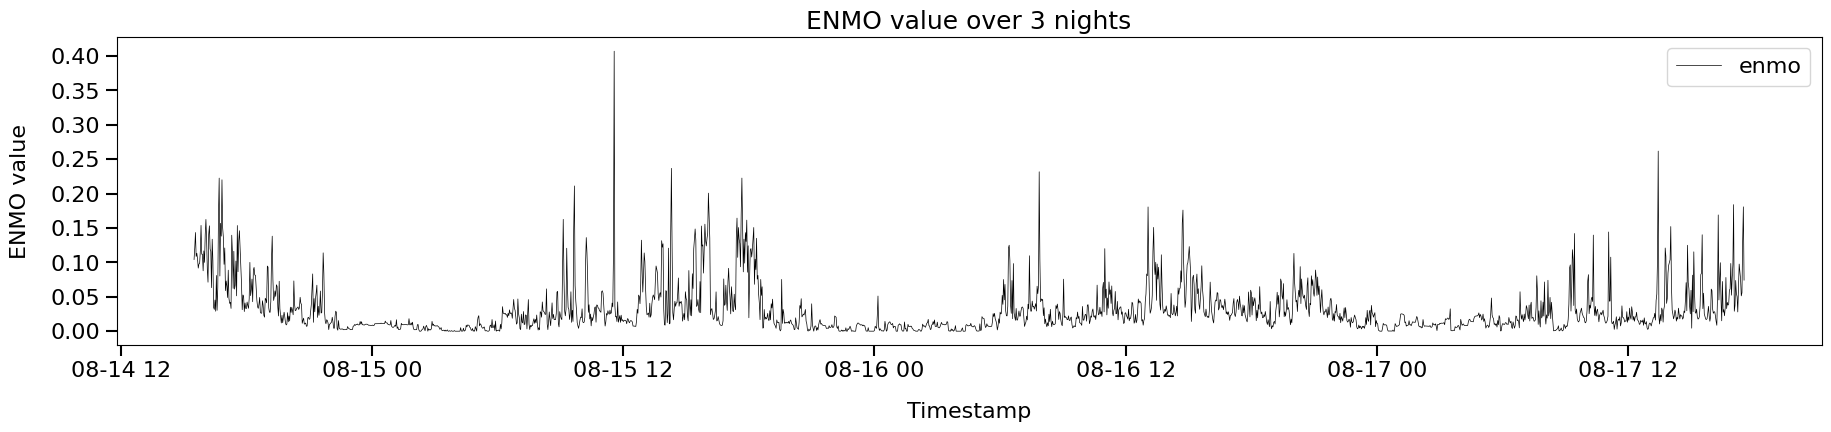

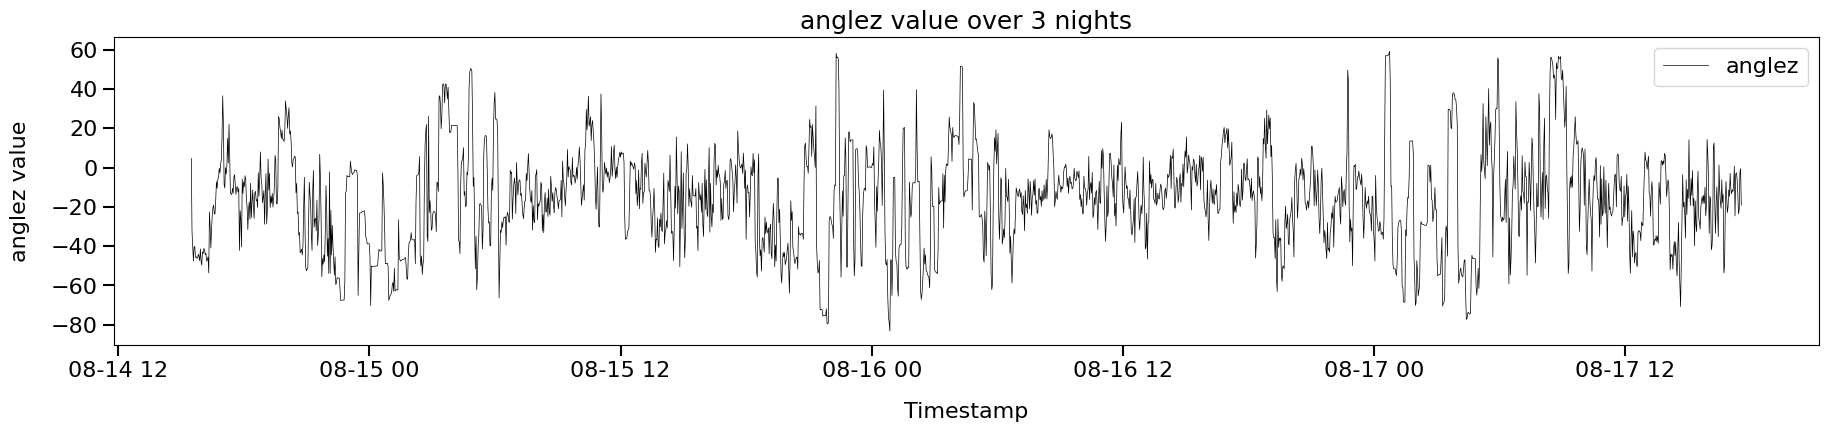

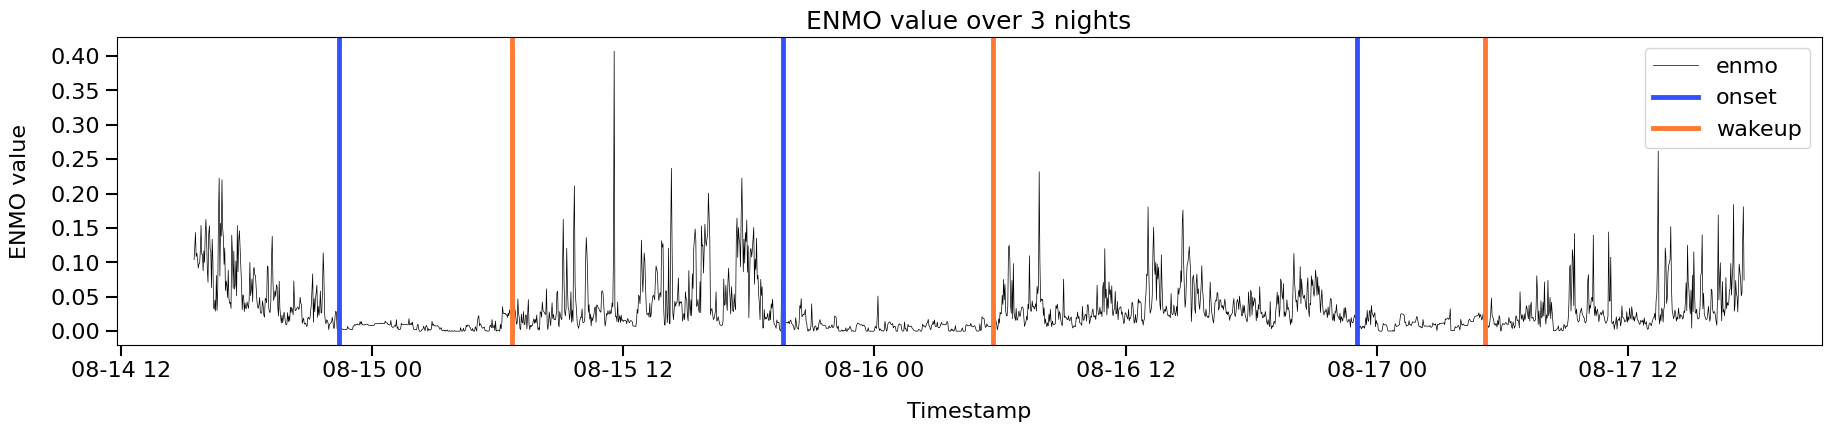

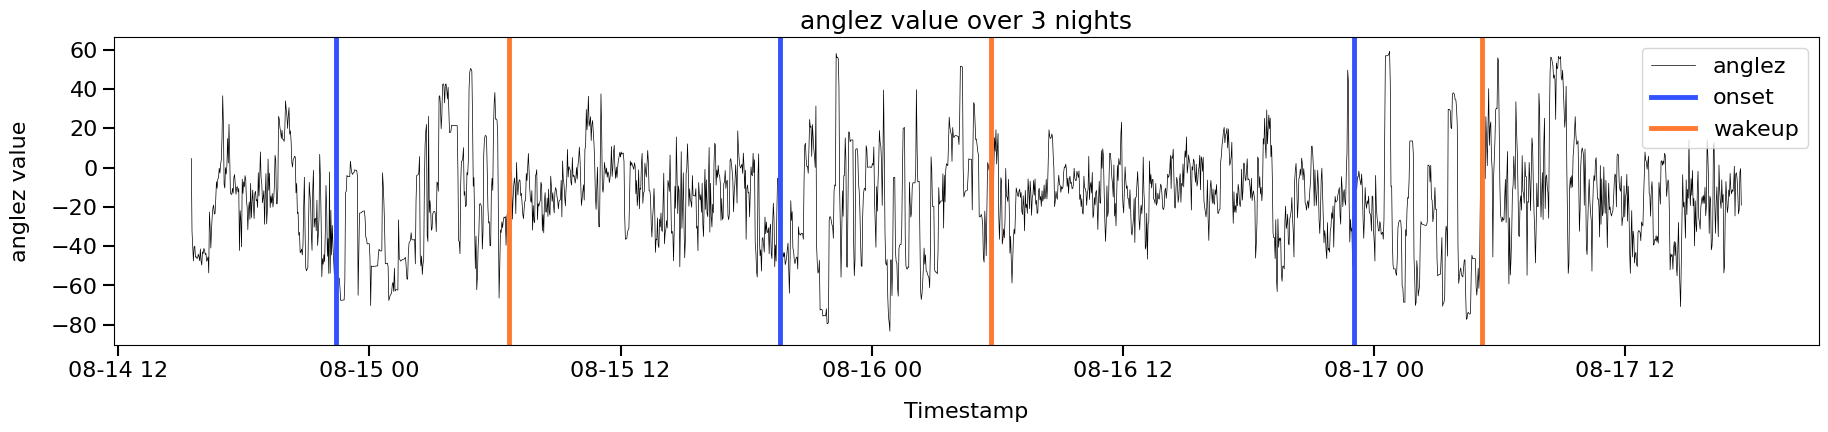

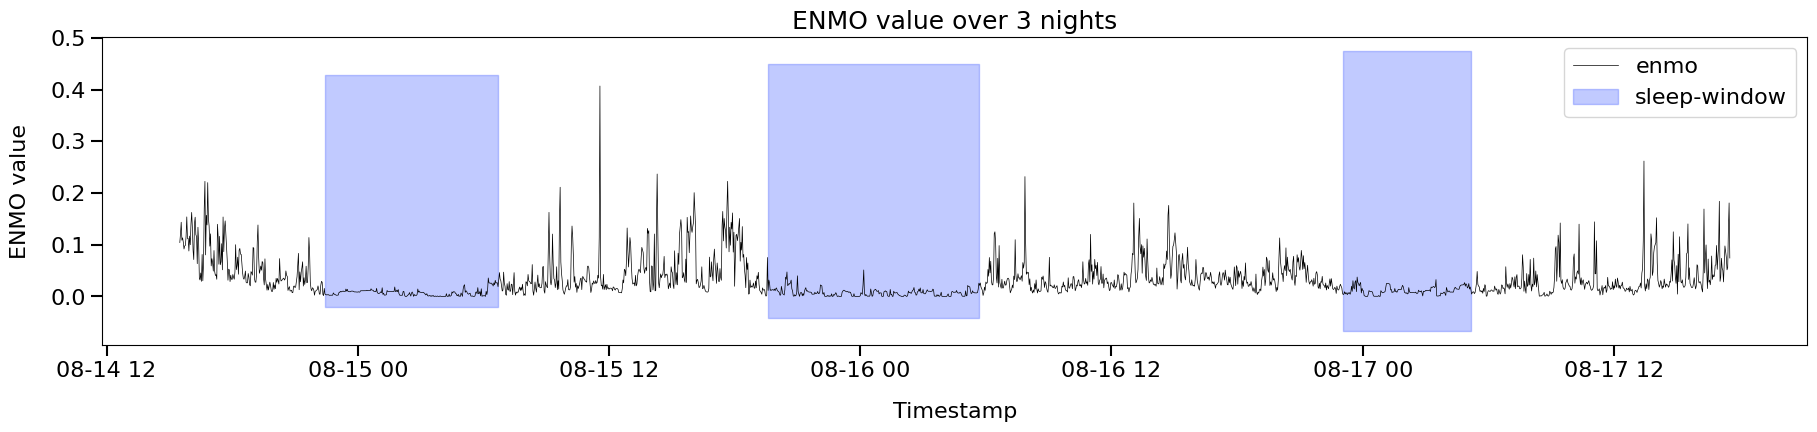

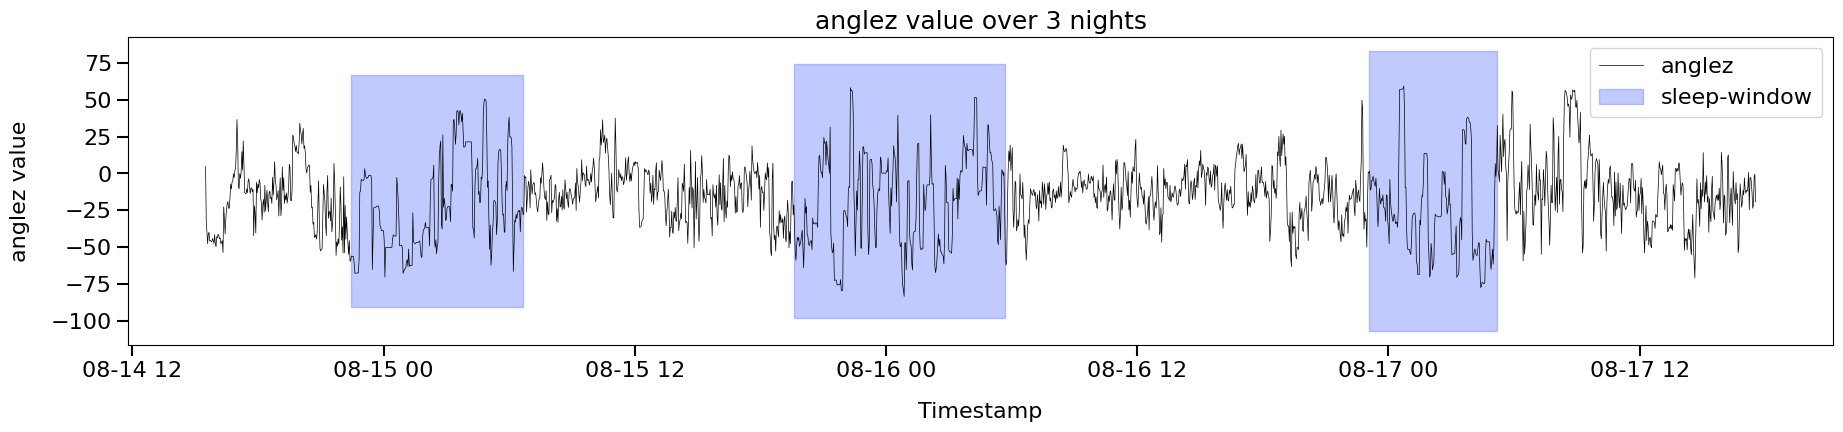

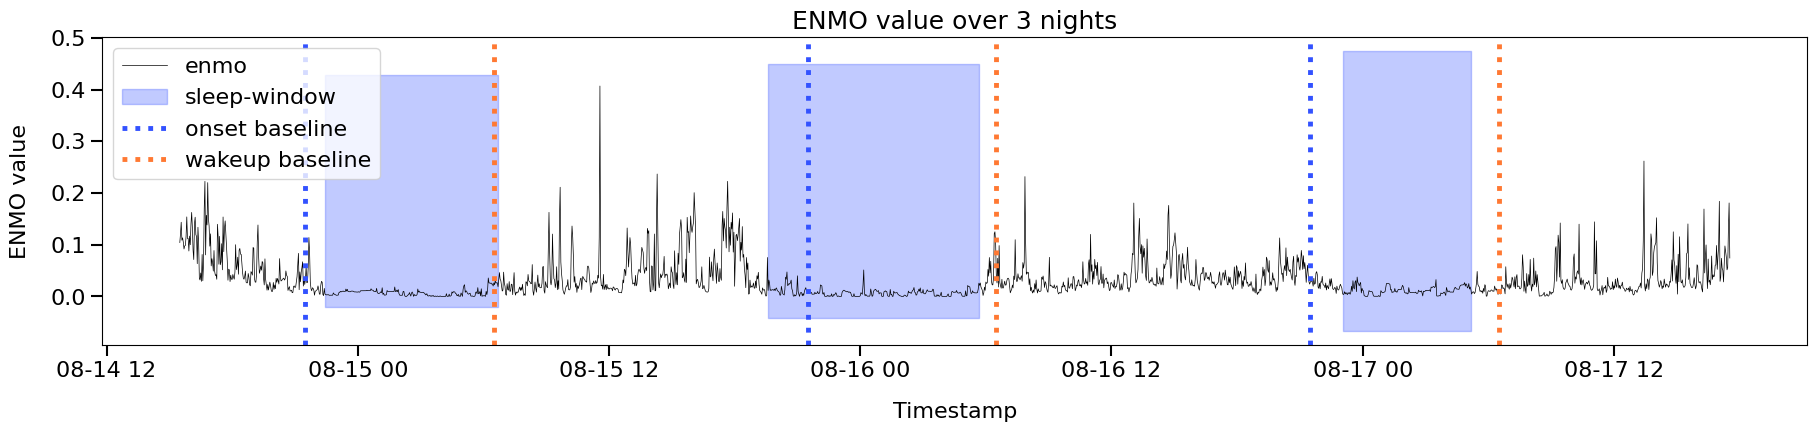

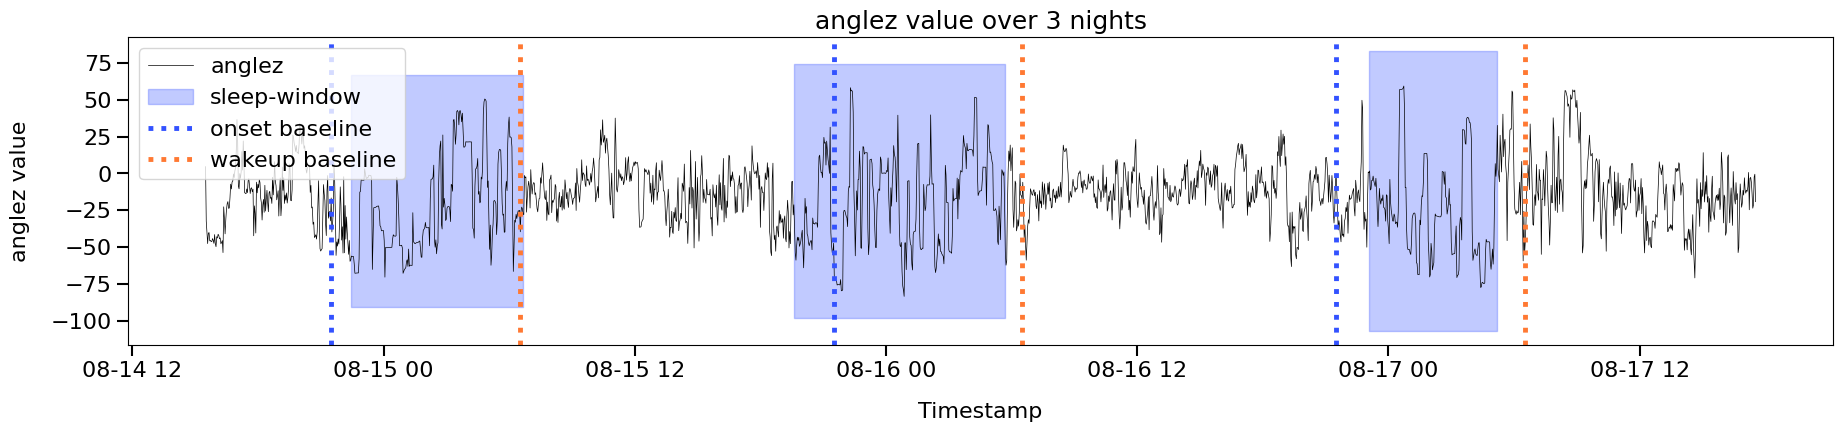

In [67]:
plot_series(series_ids, subset_series, subset_events)

In [68]:
# Assuming your DataFrame is called train_events
df_onset = train_events[train_events['event'] == 'onset']
df_wakeup = train_events[train_events['event'] == 'wakeup']

# Combine the DataFrames for plotting
combined_df = pd.concat([df_onset, df_wakeup])

# Create a histogram
fig = px.histogram(combined_df, x='hour', nbins=24, color='event', barmode='overlay',
                   labels={'hour': 'Hour of Event', 'event': 'Event'},
                   color_discrete_map={'onset': '#3352ff', 'wakeup': '#ff7933'})

# Update layout with title and x-axis range
fig.update_layout(
    title='Distribution of Onset and Wakeup Events',
    xaxis=dict(range=[0, 23], tickvals=list(range(24)))
)

# Show the plot
fig.show()